1. Importation des bibliothèques

In [1]:

# Importation des librairies necessaires pour les calculs et les affichages
import numpy as np
import matplotlib.pyplot as plt
import cv2


2. Chargement et prétraitement de l'image

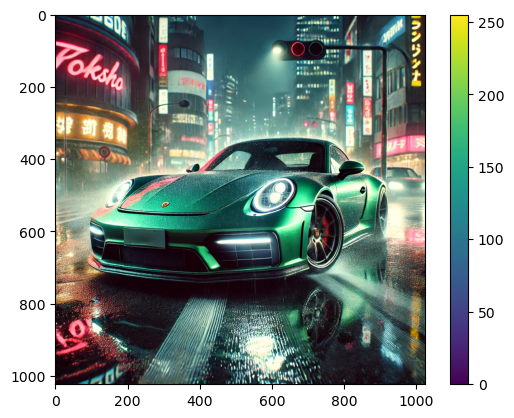

In [2]:

img= cv2.imread('tydrift.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img)
plt.colorbar()
plt.show()

3. Initialisation des paramètres pour Fuzzy C-means et son implementation 

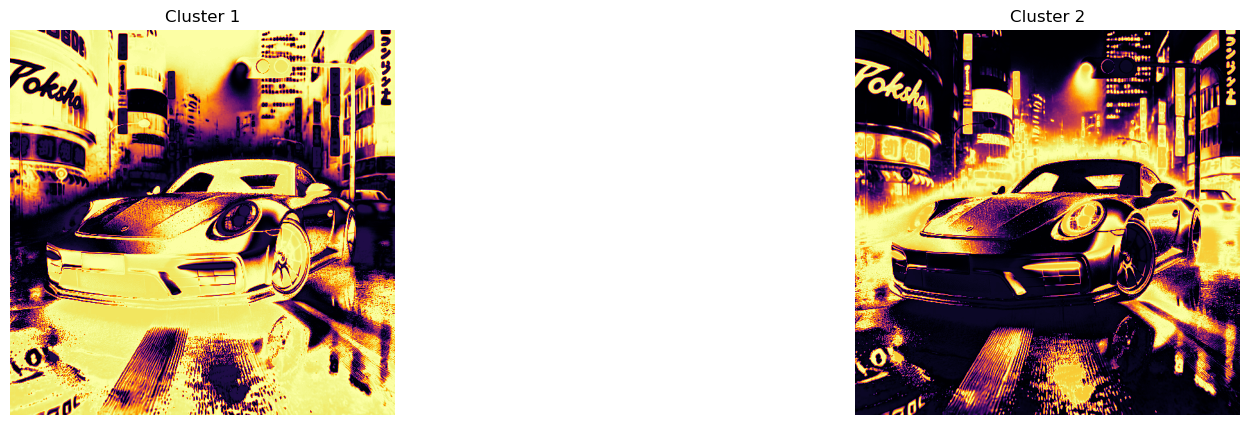

In [3]:
# initialisation de la matrice d'appartenance : 
def init_matrice_appartenance(X, C, m):
    n_samples = X.shape[0].X.shape[1]
    c_clusters = C.shape[0]

    U = np.zeros((n_samples, c_clusters))

    for i in range(n_samples):
        for j in range(c_clusters):
            somme = 0
            for k in range(c_clusters):
                dist_ij = np.linalg.norm(X[i] - C[j])
                dist_ik = np.linalg.norm(X[i] - C[k])
                if dist_ik == 0:
                    dist_ik = np.finfo(np.float64).eps
                somme += (dist_ij / dist_ik) ** (2 / (m - 1))
            U[i, j] = 1 / somme

    return U

#Algorithme Cfuzzy
def fuzzy_c_means_segmentation(image, n_clusters, m=2, max_iter=100, error=1e-5):

    if image is None:
        raise ValueError("L'image n'a pas été chargée correctement. Vérifiez le chemin d'accès.")


    image_resized = cv2.resize(image, (600, 600))  
    

    X = image_resized.reshape(-1, 1)
#intit des centres C 
    C = np.random.choice(np.unique(X), size=n_clusters)

    U = np.random.dirichlet(np.ones(n_clusters), size=X.shape[0])

    for iteration in range(max_iter):
        U_m = U ** m
        C_new = (U_m.T @ X) / np.sum(U_m, axis=0)[:, None]

      # Boucle de retour vers l'etape de calcul des centres
        dist = np.linalg.norm(X[:, np.newaxis] - C_new, axis=2)
        dist = np.fmax(dist, np.finfo(np.float64).eps)  
        U_new = 1 / dist ** (2 / (m - 1))
        U_new /= np.sum(U_new, axis=1, keepdims=True) 
# Si Uk+1 - Uk < eps on finis la boucle sinon on reboucle
        if np.linalg.norm(U_new - U) < error:
            break
        U = U_new


    segmented_image = U.T.reshape(n_clusters, 600, 600)

    return segmented_image, C_new
# Traitement de l'image avec CV2
def load_and_preprocess_image(image_path):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Erreur lors du chargement de l'image. Vérifiez le chemin : {image_path}")
    return image



n_clusters=2

# Définition d'une fonction d'affichage pour afficher les differentes profodeures 
def plot_segmented_images(segmented_image):
    fig, axs = plt.subplots(1, n_clusters, figsize=(20, 5))
    for i in range(n_clusters):
        axs[i].imshow(segmented_image[i], cmap= 'inferno')
        axs[i].set_title(f'Cluster {i+1}')
        axs[i].axis('off')
    plt.show()

image_path = 'tydrift.jpg'  

try:
    image = load_and_preprocess_image(image_path)

    segmented_image, centers = fuzzy_c_means_segmentation(image, n_clusters)

# En cas ou on a une erreur de chargement de fichiers 
    plot_segmented_images(segmented_image)
except ValueError as e:
    print(e)


4. Ajout de clusters (K=5)

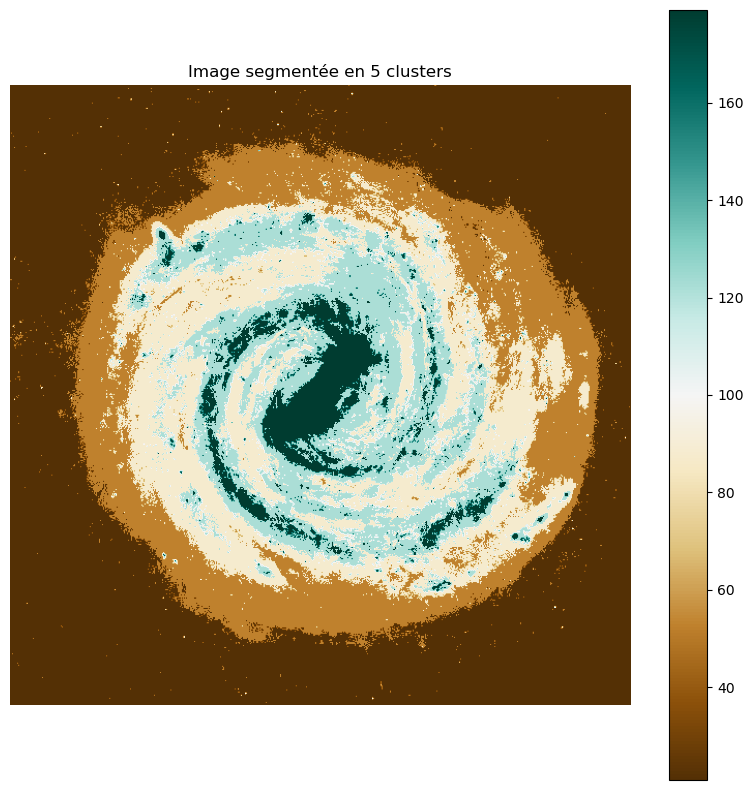

In [11]:
def init_matrice_appartenance(X, C, m):
    n_samples = X.shape[0]
    c_clusters = C.shape[0]

    U = np.zeros((n_samples, c_clusters))

    for i in range(n_samples):
        for j in range(c_clusters):
            somme = 0
            for k in range(c_clusters):
                dist_ij = np.linalg.norm(X[i] - C[j])
                dist_ik = np.linalg.norm(X[i] - C[k])
                if dist_ik == 0:
                    dist_ik = np.finfo(np.float64).eps
                somme += (dist_ij / dist_ik) ** (2 / (m - 1))
            U[i, j] = 1 / somme

    return U


def fuzzy_c_means_segmentation(image, n_clusters, m=2, max_iter=100, error=1e-5):

    if image is None:
        raise ValueError("L'image n'a pas été chargée correctement. Vérifiez le chemin d'accès.")


    image_resized = cv2.resize(image, (600, 600)) 
    
   
    X = image_resized.reshape(-1, 3) 

    random_indices = np.random.choice(X.shape[0], size=n_clusters, replace=False)
    C = X[random_indices] 

    U = np.random.dirichlet(np.ones(n_clusters), size=X.shape[0])

    for iteration in range(max_iter):
        U_m = U ** m
        C_new = (U_m.T @ X) / np.sum(U_m, axis=0)[:, None]

        dist = np.linalg.norm(X[:, np.newaxis] - C_new, axis=2) 
        dist = np.fmax(dist, np.finfo(np.float64).eps)  
        U_new = 1 / dist ** (2 / (m - 1))
        U_new /= np.sum(U_new, axis=1, keepdims=True) 

        if np.linalg.norm(U_new - U) < error:
            break
        U = U_new


    segmented_image = np.zeros_like(X)
    cluster_labels = np.argmax(U, axis=1)

    for i in range(n_clusters):
        segmented_image[cluster_labels == i] = C_new[i]

    segmented_image = segmented_image.reshape(600, 600, 3)

    return segmented_image.astype(np.uint8), C_new


def load_and_preprocess_image(image_path):

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Erreur lors du chargement de l'image. Vérifiez le chemin : {image_path}")

    return image

def plot_segmented_images_color(segmented_image, n_clusters):
    plt.figure(figsize=(10, 10))
    
    grayscale_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)
    
    plt.imshow(grayscale_image, cmap='BrBG')

    plt.title(f'Image segmentée en {n_clusters} clusters')

    plt.axis('off')

    plt.colorbar()

    plt.show()



image_path = 'milky-way.jpg'  
n_clusters = 5
try:
    image = load_and_preprocess_image(image_path)

    segmented_image, centers = fuzzy_c_means_segmentation(image, n_clusters)

 
    plot_segmented_images_color(segmented_image, n_clusters)
except ValueError as e:
    print(e)


Pour cette partie on va appliquer le clustering sur une image en couleur et appliquer 10 clusters pour avoir une bonne representation.

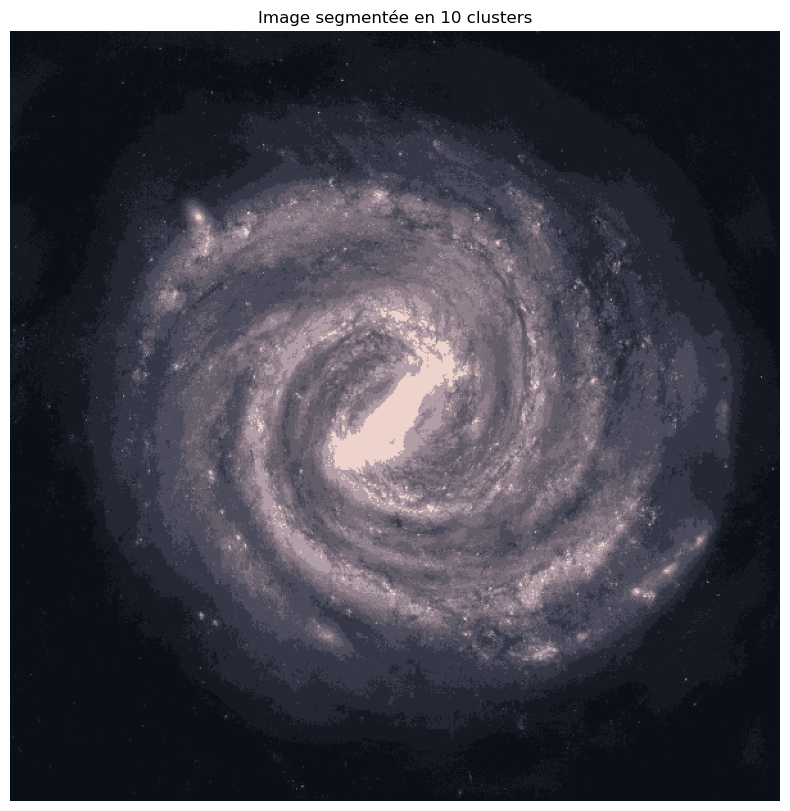

In [13]:
def init_matrice_appartenance(X, C, m):
    n_samples = X.shape[0]
    c_clusters = C.shape[0]

    U = np.zeros((n_samples, c_clusters))

    for i in range(n_samples):
        for j in range(c_clusters):
            somme = 0
            for k in range(c_clusters):
                dist_ij = np.linalg.norm(X[i] - C[j])
                dist_ik = np.linalg.norm(X[i] - C[k])
                if dist_ik == 0:
                    dist_ik = np.finfo(np.float64).eps
                somme += (dist_ij / dist_ik) ** (2 / (m - 1))
            U[i, j] = 1 / somme

    return U


def fuzzy_c_means_segmentation(image, n_clusters, m=2, max_iter=100, error=1e-5):

    if image is None:
        raise ValueError("L'image n'a pas été chargée correctement. Vérifiez le chemin d'accès.")


    image_resized = cv2.resize(image, (600, 600)) 
    
   
    X = image_resized.reshape(-1, 3) 

    random_indices = np.random.choice(X.shape[0], size=n_clusters, replace=False)
    C = X[random_indices] 

    U = np.random.dirichlet(np.ones(n_clusters), size=X.shape[0])

    for iteration in range(max_iter):
        U_m = U ** m
        C_new = (U_m.T @ X) / np.sum(U_m, axis=0)[:, None]

        dist = np.linalg.norm(X[:, np.newaxis] - C_new, axis=2) 
        dist = np.fmax(dist, np.finfo(np.float64).eps)  
        U_new = 1 / dist ** (2 / (m - 1))
        U_new /= np.sum(U_new, axis=1, keepdims=True) 

        if np.linalg.norm(U_new - U) < error:
            break
        U = U_new


    segmented_image = np.zeros_like(X)
    cluster_labels = np.argmax(U, axis=1)

    for i in range(n_clusters):
        segmented_image[cluster_labels == i] = C_new[i]

    segmented_image = segmented_image.reshape(600, 600, 3)

    return segmented_image.astype(np.uint8), C_new


def load_and_preprocess_image(image_path):

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Erreur lors du chargement de l'image. Vérifiez le chemin : {image_path}")

    return image

def plot_segmented_images_color(segmented_image, n_clusters):
    plt.figure(figsize=(10, 10))
    
    grayscale_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(grayscale_image, cmap='inferno')

    plt.title(f'Image segmentée en {n_clusters} clusters')

    plt.axis('off')

    plt.show()



image_path = 'milky-way.jpg'  
n_clusters = 10
try:
    image = load_and_preprocess_image(image_path)

    segmented_image, centers = fuzzy_c_means_segmentation(image, n_clusters)

 
    plot_segmented_images_color(segmented_image, n_clusters)
except ValueError as e:
    print(e)



5. Extraction de pixels random et mesure de degrés d'appartenance à chaque cluster


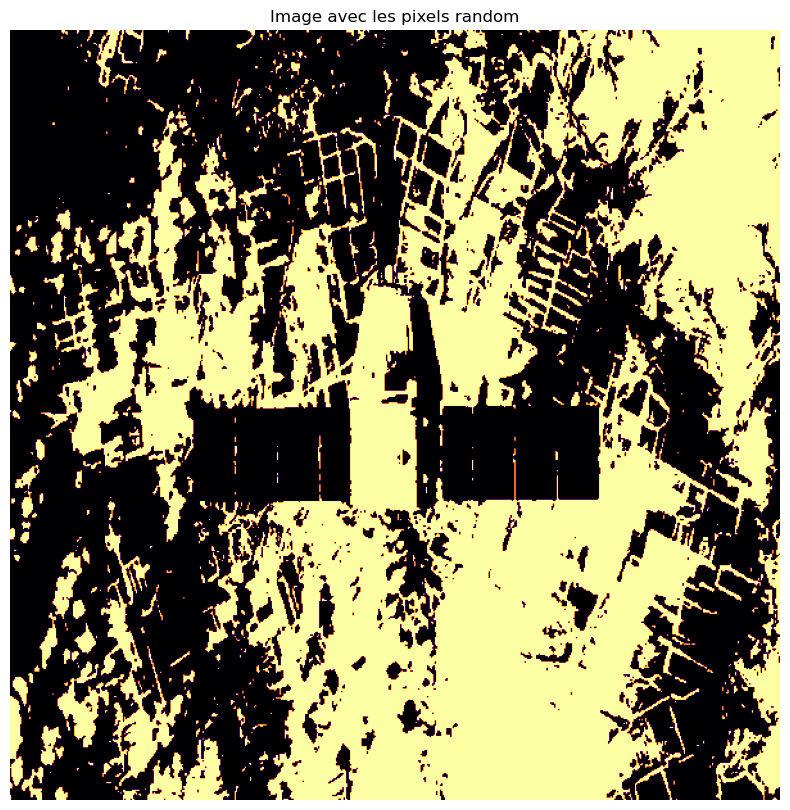

Pixel 1 : [0.98675259 0.01324741], Somme: 1.0
Pixel 2 : [0.00764106 0.99235894], Somme: 1.0
Pixel 3 : [0.21762344 0.78237656], Somme: 1.0
Pixel 4 : [0.97432802 0.02567198], Somme: 1.0
Pixel 5 : [0.23085482 0.76914518], Somme: 1.0
Pixel 6 : [0.21633633 0.78366367], Somme: 1.0
Pixel 7 : [0.17863551 0.82136449], Somme: 1.0
Pixel 8 : [0.65887677 0.34112323], Somme: 1.0
Pixel 9 : [0.0037721 0.9962279], Somme: 0.9999999999999999
Pixel 10 : [0.03344558 0.96655442], Somme: 1.0


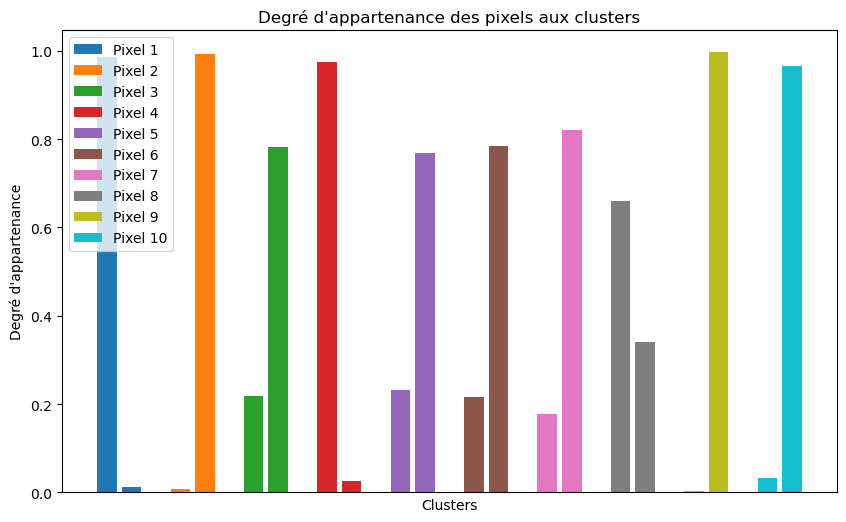

In [23]:
#Le but est d'extraire de nos images les pixels et tester leur degré d'appartenance 
def display_clusters_and_membership_matrix(image, U, random_pixels, random_indices, n_clusters):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap= 'inferno')
    plt.title("Image avec les pixels random")
    plt.axis('off')
    plt.show()


 
    selected_membership_matrix = U[random_indices]


    for i, row in enumerate(selected_membership_matrix):
        print(f"Pixel {i + 1} : {row}, Somme: {np.sum(row)}")


    plt.figure(figsize=(10, 6))
    for i, row in enumerate(selected_membership_matrix):
        plt.bar(np.arange(n_clusters) + i * (n_clusters + 1), row, width=0.8, label=f'Pixel {i+1}')
    
    plt.xlabel('Clusters')
    plt.ylabel('Degré d\'appartenance')
    plt.title('Degré d\'appartenance des pixels aux clusters')
    plt.xticks([])
    plt.legend(loc='best')
    plt.show()

def extract_random_pixels_and_display_clusters(image, U, N, n_clusters):

    flat_image = image.reshape(-1, 3)  


    random_indices = np.random.choice(flat_image.shape[0], size=N, replace=False)


    random_pixels = flat_image[random_indices]
    

    display_clusters_and_membership_matrix(image, U, random_pixels, random_indices, n_clusters)
    return random_pixels


def fuzzy_c_means_segmentation_with_membership(image, n_clusters, m=2, max_iter=100, error=1e-5):

    image_resized = cv2.resize(image, (600, 600))  
    

    X = image_resized.reshape(-1, 3)  


    random_indices = np.random.choice(X.shape[0], size=n_clusters, replace=False)
    C = X[random_indices] 


    U = np.random.dirichlet(np.ones(n_clusters), size=X.shape[0])

    for iteration in range(max_iter):
        U_m = U ** m
        C_new = (U_m.T @ X) / np.sum(U_m, axis=0)[:, None]

    
        dist = np.linalg.norm(X[:, np.newaxis] - C_new, axis=2)  
        dist = np.fmax(dist, np.finfo(np.float64).eps)  
        U_new = 1 / dist ** (2 / (m - 1))
        U_new /= np.sum(U_new, axis=1, keepdims=True)  

        if np.linalg.norm(U_new - U) < error:
            break
        U = U_new


    segmented_image = np.zeros_like(X)
    cluster_labels = np.argmax(U, axis=1)

    for i in range(n_clusters):
        segmented_image[cluster_labels == i] = C_new[i]


    segmented_image = segmented_image.reshape(600, 600, 3)

    return segmented_image.astype(np.uint8), U  


image_path = 'satellite.jpg'  
n_clusters = 2
N = 10  

try:
    image = load_and_preprocess_image(image_path)

    segmented_image, U = fuzzy_c_means_segmentation_with_membership(image, n_clusters)


    random_pix =  extract_random_pixels_and_display_clusters(segmented_image, U, N, n_clusters)

except ValueError as e:
    print(e)


In [17]:
print (random_pix)
flat_pix = random_pix.flatten()

[[180 184 185]
 [180 184 185]
 [115 104  98]
 [115 104  98]
 [115 104  98]
 [115 104  98]
 [180 184 185]
 [115 104  98]
 [115 104  98]
 [180 184 185]]


6. Affichage des pixels en question 

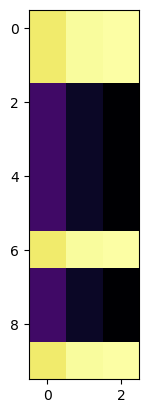

In [20]:

plt.figure()
plt.imshow(random_pix, cmap= 'inferno')
